In [304]:
# !pip install optuna -q
import pandas as pd
import numpy as np 
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["figure.dpi"] = 100

## Pre-processing the data

In [169]:
# Works great
# Load the dataset
file_path = 'training_data.csv'
data = pd.read_csv(file_path)
data['increase_stock_binary'] = data['increase_stock'].apply(lambda x: 1 if x == 'high_bike_demand' else 0)

corr_coeffs = data.drop(['increase_stock','snow','holiday'], axis=1).corr().iloc[-1].sort_values()
print(corr_coeffs.round(2))
important_features = corr_coeffs.iloc[:2].keys().tolist() + corr_coeffs.iloc[-7:].keys().tolist()
print(corr_coeffs.round(2)[important_features])

X = data[important_features].drop('increase_stock_binary', axis=1).to_numpy().astype(np.float32)
y = data['increase_stock_binary'].to_numpy().astype(np.float32)

scaler = MinMaxScaler() 
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)[:,None]
X_test  = torch.tensor(X_test)
y_test  = torch.tensor(y_test)[:,None]

X = torch.cat([X_train, X_test], 0)
y = torch.cat([y_train, y_test], 0)

humidity                -0.31
weekday                 -0.12
precip                  -0.06
snowdepth               -0.05
cloudcover              -0.05
month                    0.04
day_of_week              0.08
windspeed                0.10
visibility               0.11
dew                      0.13
summertime               0.22
hour_of_day              0.24
temp                     0.34
increase_stock_binary    1.00
Name: increase_stock_binary, dtype: float64
humidity                -0.31
weekday                 -0.12
windspeed                0.10
visibility               0.11
dew                      0.13
summertime               0.22
hour_of_day              0.24
temp                     0.34
increase_stock_binary    1.00
Name: increase_stock_binary, dtype: float64


## Onehot encoding

In [305]:
np.random.seed(0)
file_path = 'training_data.csv'
data = pd.read_csv(file_path)
data['increase_stock_binary'] = data['increase_stock'].map(lambda x: 0 if x == 'low_bike_demand' else 1)
data = data.drop(['snow', 'increase_stock'], axis=1)

# pick out the labels
y = data['increase_stock_binary'].to_numpy().astype(np.float32)
y = torch.tensor(y).unsqueeze(-1)
data = data.drop(['increase_stock_binary'], axis=1)

# Separating the numerical and categorical data to handle them separately
cat_data = pd.DataFrame({key:data[key] for key in data.keys() if data[key].dtype == int})
num_data = pd.DataFrame({key:data[key] for key in data.keys() if data[key].dtype == float})

# performing onehot encoding on the categorical data
cat_data = torch.from_numpy(cat_data.to_numpy())
cat_onehot = torch.cat([F.one_hot(x, num_classes=24) for x in cat_data]).view(cat_data.shape[0], -1)

# constructing the complete input dataset
data = np.concatenate([num_data.to_numpy(), cat_onehot.numpy()], axis=-1).astype(np.float32)

# scaling
X = MinMaxScaler().fit_transform(data) 
X = torch.tensor(X)

# prepare train and test data
#n_splits = 5
#kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
#train_index, test_index = list(kf.split(X))[0]
#X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([1200, 152]) torch.Size([400, 152]) torch.Size([1200, 1]) torch.Size([400, 1])


# Transformer
Does not work as good as DNN and runs much more slowly.

In [3]:
class Transformer(nn.Module):
    def __init__(self, hidden_size, input_size, output_size, layers = 2):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        
        self.activation = nn.ReLU()
        self.input_layer = nn.Linear(self.input_size, self.hidden_size)
        self.layer_norm_input = nn.LayerNorm(self.hidden_size) 
        self.MHA = nn.MultiheadAttention(self.hidden_size, num_heads = self.hidden_size, batch_first=True)
        
        self.layer_norm_layers = nn.ModuleList() 
        self.linear_layers = nn.ModuleList()
        self.qkv_linear_layers = nn.ModuleList()

        for _ in range(layers):
            self.layer_norm_layers.append(nn.LayerNorm(self.hidden_size))
            self.linear_layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.qkv_linear_layers.append(nn.Linear(self.hidden_size, 3 * self.hidden_size))
            
        self.output_layer = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x):
        x = self.input_layer(x)
        
        for layer_norm, qkv_linear in zip(self.layer_norm_layers, self.qkv_linear_layers):
            residual = x
            qkv = qkv_linear(x).view(-1, self.hidden_size, 3)
            q, k, v = qkv[...,0], qkv[...,1], qkv[...,2]
            x, self.attn_weights = self.MHA(q, k, v)
            x = layer_norm(x) + residual
            
        x = self.output_layer(x)
        x = torch.sigmoid(x) 
        return x

## DNN
With batch normalization and residual connection.

In [436]:
class Linear(nn.Module):
    def __init__(self, input_size, output_size, seed=0, bias=True, dtype=torch.float32):
        super().__init__()
        torch.manual_seed(seed)
        self.weight = nn.Parameter(torch.randn(input_size, output_size, dtype=dtype) / (input_size + output_size))
        self.bias = nn.Parameter(torch.zeros(output_size, dtype=dtype)) if bias else None
        
    def forward(self, x):
        if self.bias is None:
            return x @ self.weight
        return x @ self.weight + self.bias
    
class DNN(nn.Module):
    def __init__(self, hidden_size, input_size, layers=2, seed=0, submodule=False):
        super().__init__()
        torch.manual_seed(seed)
        
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.submodule = submodule
        
        self.activation = nn.ReLU()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.batch_norm_input = nn.BatchNorm1d(hidden_size)  # BatchNorm for input layer
        self.linear_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()  # BatchNorm for other layers

        for _ in range(layers):
            self.linear_layers.append(nn.Linear(hidden_size, hidden_size))
            self.batch_norm_layers.append(nn.BatchNorm1d(hidden_size))

        self.output_layer = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.batch_norm_input(x)
        x = self.activation(x)

        for layer, batch_norm in zip(self.linear_layers, self.batch_norm_layers):
            residual = x
            x = layer(x)
            x = batch_norm(x)  
            x = self.activation(x + residual)
        
        if not self.submodule:
            x = self.output_layer(x)
            x = torch.sigmoid(x) 
        return x

## Training loop
Training multiple models with different weight initialization for 200 epochs.

100%|██████████| 85/85 [00:00<00:00, 189.29it/s]


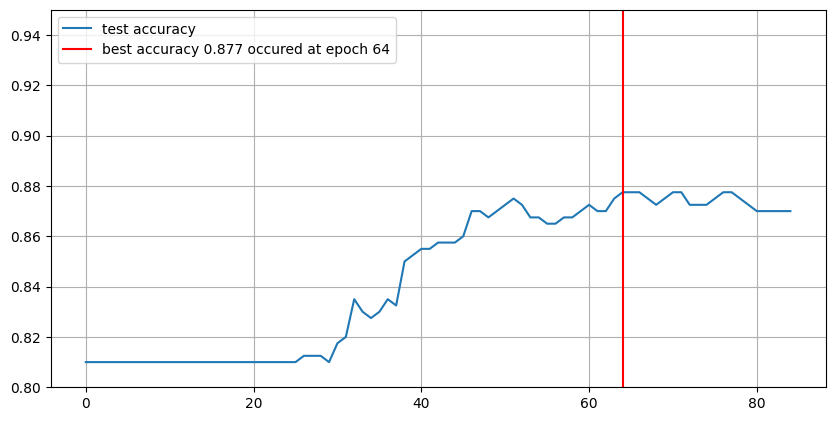

In [333]:
epochs = 84+1
metric = lambda prediction, label: (prediction.round() == label).numpy().mean()
loss_fn = torch.nn.BCELoss() 

model = DNN(17, X_train.shape[-1], 2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss_history = []
test_loss_history = []
test_metric_history = []

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    train_loss_history.append(loss.item())
    with torch.no_grad():
        y_pred_test = model(X_test)
        test_loss = loss_fn(y_pred_test, y_test)
        test_loss_history.append(test_loss.item())
        accuracy = metric(y_pred_test, y_test)
        if len(test_metric_history) > 0 and accuracy > max(test_metric_history):
            optimal_epoch = epoch
        test_metric_history.append(accuracy)
        
    
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(test_metric_history, label="test accuracy")
plt.axvline(
    optimal_epoch,
    color="red", 
    label=f"best accuracy {test_metric_history[optimal_epoch]:.3f} occured at epoch {optimal_epoch}")
plt.ylim(0.8, 0.95)
plt.legend(), plt.grid()
plt.show()

## k-fold cross validation

In [437]:
epochs = 100 #84+1
loss_fn = nn.BCELoss()
n_ensembles = 10 # checking the performance for different weight initialization
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
optimal_models = []

for n in range(n_ensembles):
    fold_performance = []
    
    for cv, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):

        model = DNN(200, X.shape[-1], 2, seed=n)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1)
        
        train_loss_history = []
        test_loss_history = []
        test_metric_history = []
        optimal_weights = 0
        
        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            model.train()
            y_pred = model(X_train[train_index])
            loss = loss_fn(y_pred, y_train[train_index])
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                model.eval()
                y_pred_test = model(X_train[test_index])
                test_loss = loss_fn(y_pred_test, y_train[test_index])
                test_loss_history.append(test_loss.item())
                accuracy = metric(y_pred_test, y_train[test_index])

                if len(test_metric_history) > 0 and accuracy > max(test_metric_history):
                    optimal_epoch = epoch
                    optimal_weights = model.state_dict()
                test_metric_history.append(accuracy)

            train_loss_history.append(loss.item())
        optimal_models.append(optimal_weights)  
        fold_performance.append(test_metric_history[optimal_epoch])
        
    mean_performance = np.mean(fold_performance)
    print(f"{optimal_epoch=}")
    print(f"Mean performance for ensemble {n}: {mean_performance:.3f} $\pm$ {np.std(fold_performance).round(3)}")
    print(f"{np.round(fold_performance, 3)}")

100%|██████████| 100/100 [00:01<00:00, 60.45it/s]


optimal_epoch=86
Mean performance for ensemble 0: 0.893 $\pm$ 0.025
[0.896 0.904 0.933 0.862 0.871]


100%|██████████| 100/100 [00:01<00:00, 61.40it/s]


optimal_epoch=87
Mean performance for ensemble 1: 0.907 $\pm$ 0.01
[0.892 0.912 0.908 0.921 0.904]


100%|██████████| 100/100 [00:01<00:00, 57.66it/s]


optimal_epoch=94
Mean performance for ensemble 2: 0.903 $\pm$ 0.009
[0.9   0.904 0.917 0.904 0.888]


100%|██████████| 100/100 [00:01<00:00, 59.70it/s]


optimal_epoch=96
Mean performance for ensemble 3: 0.905 $\pm$ 0.008
[0.908 0.908 0.917 0.892 0.9  ]


100%|██████████| 100/100 [00:01<00:00, 60.48it/s]


optimal_epoch=86
Mean performance for ensemble 4: 0.904 $\pm$ 0.014
[0.9   0.917 0.925 0.888 0.892]


100%|██████████| 100/100 [00:02<00:00, 42.21it/s]


optimal_epoch=96
Mean performance for ensemble 5: 0.893 $\pm$ 0.014
[0.875 0.904 0.912 0.883 0.888]


100%|██████████| 100/100 [00:01<00:00, 55.85it/s]


optimal_epoch=87
Mean performance for ensemble 6: 0.895 $\pm$ 0.012
[0.892 0.896 0.917 0.888 0.883]


100%|██████████| 100/100 [00:01<00:00, 60.59it/s]


optimal_epoch=98
Mean performance for ensemble 7: 0.901 $\pm$ 0.02
[0.921 0.912 0.917 0.875 0.879]


100%|██████████| 100/100 [00:01<00:00, 59.52it/s]


optimal_epoch=83
Mean performance for ensemble 8: 0.898 $\pm$ 0.009
[0.892 0.896 0.917 0.896 0.892]


100%|██████████| 100/100 [00:01<00:00, 59.96it/s]

optimal_epoch=88
Mean performance for ensemble 9: 0.900 $\pm$ 0.011
[0.892 0.912 0.912 0.896 0.888]


## Evaluation using precision and recall

In [438]:
def compute_precision(predictions, labels, positive_label=1):
    TP = torch.sum((predictions == positive_label) & (labels == positive_label)).item()
    FP = torch.sum((predictions == positive_label) & (labels != positive_label)).item()
    return TP / (TP + FP) if (TP + FP) > 0 else 0

def compute_recall(predictions, labels, positive_label=1):
    TP = torch.sum((predictions == positive_label) & (labels == positive_label)).item()
    FN = torch.sum((predictions != positive_label) & (labels == positive_label)).item()
    return TP / (TP + FN) if (TP + FN) > 0 else 0


def DeepNeuralNetworkEnsemble(optimal_models):
    DNN_ensemble = []
    for weights in optimal_models:
        model = DNN(200, X.shape[-1], 2)
        model.load_state_dict(weights)
        y_pred = model(X_test)
        DNN_ensemble.append(y_pred.detach().numpy())
    return torch.Tensor(DNN_ensemble).mean(0).round()
    
prediction = DeepNeuralNetworkEnsemble(optimal_models)
accuracy = metric(prediction, y_test)

print(round(accuracy, 2))
for positive_label in [0, 1]:
    recall = compute_recall(prediction, y_test, positive_label)
    precision = compute_precision(prediction, y_test, positive_label)
    print(round(precision, 2), round(recall, 2))

0.9
0.93 0.94
0.74 0.71


## Best model 
The DNN has the highest accuracy 0.90.

In [392]:
pretrained_model = DNN(17, X_train.shape[-1], 2)
pretrained_model.load_state_dict(optimal_weights)

pretrained_model.eval()
with torch.no_grad():
    y_pred = pretrained_model(X_test)
    
metric(y_pred, y_test)

0.8825

## Gradient Boosting
Can improve upon the best model with 1 percentage.

100%|██████████| 4/4 [00:00<00:00, 238.69it/s]

0.903125 2


0.9

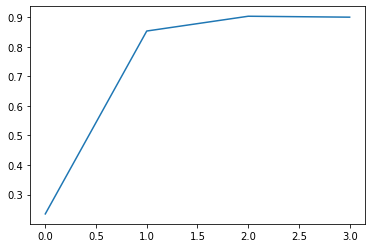

In [126]:
epochs = 4
model = DNN(5, 1, layers=1, seed=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
test_metric_history = []

with torch.no_grad():
    base_train_pred = pretrained_model(X_train)
    base_test_pred  = pretrained_model(X_test)

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    new_train_input = base_train_pred
    model.train()
    y_pred = model(new_train_input)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step() 

    with torch.no_grad():
        new_test_input = base_test_pred
        model.eval()
        y_pred_test = model(new_test_input)
        accuracy = metric(y_pred_test, y_test)
        if len(test_metric_history) > 0 and accuracy > max(test_metric_history):
            optimal_epoch = epoch
            optimal_weights = model.state_dict()
        test_metric_history.append(accuracy)
        
plt.plot(test_metric_history)
print(max(test_metric_history), optimal_epoch)
metric(model(pretrained_model(X_test)), y_test)

## Baseline
There are 82% zeros in the whole dataset. So a naive classifier that only predicts zeros will achive 82% accuracy.

## Tuning
Finding the optimal hidden size and number of layers using optuna.

In [114]:
epochs = 200
def objective(trial):
    
    hidden_size = trial.suggest_int('hidden_size', 10, 500)
    layers = trial.suggest_int('layers', 1, 20)

    model = DNN(hidden_size, X_train.shape[-1], y_train.shape[-1], layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.BCELoss()
    test_metric_history = []

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_pred = model(X_test)
            accuracy = metric(y_pred, y_test)
            test_metric_history.append(accuracy)

    return np.max(accuracy) 

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print(study.best_trial)

[I 2023-11-13 14:18:09,512] A new study created in memory with name: no-name-4dd84a08-08ef-4f22-a1f8-b200f9ab5c5f
100%|██████████| 200/200 [00:06<00:00, 30.36it/s]
[I 2023-11-13 14:18:16,342] Trial 0 finished with value: 0.8566666666666667 and parameters: {'hidden_size': 157, 'layers': 6}. Best is trial 0 with value: 0.8566666666666667.
100%|██████████| 200/200 [00:10<00:00, 19.34it/s]
[I 2023-11-13 14:18:26,694] Trial 1 finished with value: 0.8383333333333334 and parameters: {'hidden_size': 459, 'layers': 2}. Best is trial 0 with value: 0.8566666666666667.
100%|██████████| 200/200 [00:02<00:00, 90.95it/s]
[I 2023-11-13 14:18:28,905] Trial 2 finished with value: 0.825 and parameters: {'hidden_size': 30, 'layers': 6}. Best is trial 0 with value: 0.8566666666666667.
100%|██████████| 200/200 [00:05<00:00, 36.65it/s]
[I 2023-11-13 14:18:34,371] Trial 3 finished with value: 0.8316666666666667 and parameters: {'hidden_size': 139, 'layers': 6}. Best is trial 0 with value: 0.8566666666666667.


FrozenTrial(number=465, state=TrialState.COMPLETE, values=[0.8916666666666667], datetime_start=datetime.datetime(2023, 11, 13, 14, 56, 30, 924158), datetime_complete=datetime.datetime(2023, 11, 13, 14, 56, 32, 117906), params={'hidden_size': 17, 'layers': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_size': IntDistribution(high=500, log=False, low=10, step=1), 'layers': IntDistribution(high=20, log=False, low=1, step=1)}, trial_id=465, value=None)


## Conclusion
The best model has two layers each with 17 units 0.8917, not that it is possible to go higher with 